# 509 Final Project

## Globally import libraries

In [1]:
import numpy as np
import pandas as pd
import pymysql as mysql
import matplotlib.pyplot as plt
import os
import shutil
import re
import logging
import time
import datetime as dt
import zipfile
import requests
from bs4 import BeautifulSoup
import datetime
import re
import regex as rex
from collections import defaultdict, Counter
import random
import json
from string import punctuation
import itertools
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
import spacy

#import mysql.connector

# Set pandas global options
pd.options.display.max_rows = 17

%matplotlib inline

## Upload data from CSV

In [2]:
'''Dir nav citation:
https://softhints.com/python-change-directory-parent/'''
curr_dir = os.path.abspath(os.curdir)
print(curr_dir)
os.chdir("..")
up1_dir = os.path.abspath(os.curdir)
print(up1_dir)

C:\Users\acarr\Documents\GitHub\ADS509_Final_project\deliverables
C:\Users\acarr\Documents\GitHub\ADS509_Final_project


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = 'data'

file_in_name01 = 'master.csv'

file_in_path01 = os.path.join(up1_dir, data_location, file_in_name01)

print(f'CSV file 1 in path: {file_in_path01}')

CSV file 1 in path: C:\Users\acarr\Documents\GitHub\ADS509_Final_project\data\master.csv


### Review dataframe

In [4]:
slct_tbl_full_df01 = pd.read_csv(file_in_path01)
print(f'Dataframe shape: {slct_tbl_full_df01.shape}')
display(slct_tbl_full_df01.head())

Dataframe shape: (4509, 7)


source_name          author  \
0  The Washington Post             NaN   
1  The Washington Post  Amber Phillips   
2  The Washington Post    David Ovalle   
3  The Washington Post     Philip Bump   
4  The Washington Post             NaN   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4          The revolt of Christian home-schoolers...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/education/inter...  2023-05-30T18:25:37Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Deep Reads features The Washington Posts best ...   

                                        article_text  
0  Travelers in Alabama driving on Interstate 65 ...  
1  A federal prosecutor may be nearing a decision...  
2  A federal appeals court Tuesday cleared the wa...  
3  Speaking in Orlando in November 2015, Republic...  
4                                                NaN

## Exploratory Data Analysis (EDA)

### Count missing `article_text` feature

In [5]:
count_nan = slct_tbl_full_df01.isnull().sum()
 
# printing the number of values present
# in the column
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: source_name        0
author            37
title              0
url                0
publish_date       0
content         3351
article_text       1
dtype: int64


### Count blank `article_text` feature

In [6]:
print(len(slct_tbl_full_df01[slct_tbl_full_df01['article_text']=='']))
display(slct_tbl_full_df01[slct_tbl_full_df01['article_text']==''].head(20))

0


Empty DataFrame
Columns: [source_name, author, title, url, publish_date, content, article_text]
Index: []

### Remove missing `article_text` rows

In [7]:
'''Drop missing citation:
https://pandas.pydata.org/pandas-docs/stable/reference
/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna'''
slct_tbl_full_df02 = slct_tbl_full_df01.dropna(subset=['article_text'])
print(f'Dataframe shape: {slct_tbl_full_df02.shape}')
display(slct_tbl_full_df02.head())

Dataframe shape: (4508, 7)


source_name          author  \
0  The Washington Post             NaN   
1  The Washington Post  Amber Phillips   
2  The Washington Post    David Ovalle   
3  The Washington Post     Philip Bump   
5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
5  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
5  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
5  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  
0  Travelers in Alabama driving on Interstate 65 ...  
1  A federal prosecutor may be nearing a decision...  
2  A federal appeals court Tuesday cleared the wa...  
3  Speaking in Orlando in November 2015, Republic...  
5  “Look, we know our country’s going in the wron...

In [8]:
tqdm.pandas(ncols=50)  # can use tqdm_gui, optional kwargs, etc
# Now you can use `progress_apply` instead of `apply`

# Raw text character and word counts
slct_tbl_full_df02['char_cnt'] = slct_tbl_full_df02['article_text'].progress_apply(len)
slct_tbl_full_df02['word_cnt'] = slct_tbl_full_df02['article_text'].progress_apply(lambda x: len(x.split()))
display(slct_tbl_full_df02.head())

100%|█████| 4508/4508 [00:00<00:00, 938451.58it/s]
C:\Users\acarr\AppData\Local\Temp\ipykernel_22900\1419634614.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slct_tbl_full_df02['char_cnt'] = slct_tbl_full_df02['article_text'].progress_apply(len)
100%|██████| 4508/4508 [00:00<00:00, 22956.54it/s]
C:\Users\acarr\AppData\Local\Temp\ipykernel_22900\1419634614.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slct_tbl_full_df02['word_cnt'] = slct_tbl_full_df02['article_text'].progress_apply(lambda x: len

source_name          author  \
0  The Washington Post             NaN   
1  The Washington Post  Amber Phillips   
2  The Washington Post    David Ovalle   
3  The Washington Post     Philip Bump   
5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
5  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
5  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
5  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  
0  Travelers in Alabama driving on Interstate 65 ...      5746       920  
1  A federal prosecutor may be nearing a decision...      6814      1089  
2  A federal appeals court Tuesday cleared the wa...      5479       869  
3  Speaking in Orlando in November 2015, Republic...      5907       955  
5  “Look, we know our country’s going in the wron...      4563       750

### Descriptive statistics

In [9]:
slct_tbl_full_df02[['source_name',
                    'author',
                    'publish_date',
                    'article_text']].describe(include="O").T

count unique                                                top  \
source_name   4508      4                                           Fox News   
author        4472    956                                   Associated Press   
publish_date  4508   4486                               2023-05-13T11:00:00Z   
article_text  4508   4508  Travelers in Alabama driving on Interstate 65 ...   

              freq  
source_name   2192  
author         450  
publish_date     3  
article_text     1

In [10]:
slct_tbl_full_df02.describe().T

count         mean          std    min     25%     50%     75%  \
char_cnt  4508.0  4655.501109  3137.364995  131.0  2832.0  3951.5  5664.5   
word_cnt  4508.0   731.031500   518.576508   16.0   432.0   607.0   889.0   

              max  
char_cnt  80585.0  
word_cnt  14322.0

In [11]:
slct_tbl_full_df02['source_name'].value_counts()

Fox News               2192
Breitbart News         1017
CNN                     773
The Washington Post     526
Name: source_name, dtype: int64

### Examine inclusion of "centrist" sources indicated by `author` feature

In [12]:
slct_tbl_full_df02a = slct_tbl_full_df02[slct_tbl_full_df02['author'].isin(['msn', 'Associated Press', 'Reuters'])]

display(slct_tbl_full_df02a[slct_tbl_full_df02a['author']=='msn'])

display(slct_tbl_full_df02a.groupby(by=['source_name', 'author']).count())

source_name author  \
17   The Washington Post    msn   
18   The Washington Post    msn   
22   The Washington Post    msn   
81   The Washington Post    msn   
84   The Washington Post    msn   
..                   ...    ...   
492  The Washington Post    msn   
502  The Washington Post    msn   
503  The Washington Post    msn   
506  The Washington Post    msn   
509  The Washington Post    msn   

                                                 title  \
17       State Dept seeks to expand space diplomacy...   
18                            SHOCK IN RUSSIAN CAPITAL   
22   Debate over whether AI will destroy us is divi...   
81   Corporate bankruptcies creeping up as pressure...   
84    The looming existential crisis for cable news...   
..                                                 ...   
492  Biden shows growing appetite to cross Putin's ...   
502  Behind-the-scenes videos of Tucker Carlson wer...   
503  Georgia probe of Trump broadens to activities ...   
506  DRAMA: Couple, both nurses, save man's life mi...   
509  'DRAG RACE' queen says cancellation of militar...   

                                                   url          publish_date  \
17   https://www.washingtonpost.com/technology/2023...  2023-05-30T17:00:04Z   
18   https://www.washingtonpost.com/world/2023/05/3...  2023-05-30T13:00:04Z   
22   https://www.washingtonpost.com/technology/2023...  2023-05-20T21:00:04Z   
81   https://www.washingtonpost.com/business/2023/0...  2023-05-23T12:00:04Z   
84   https://www.washingtonpost.com/media/2023/05/2...  2023-05-23T14:00:04Z   
..                                                 ...                   ...   
492  https://www.washingtonpost.com/national-securi...  2023-06-01T11:00:04Z   
502  https://www.washingtonpost.com/media/2023/06/0...  2023-06-02T02:00:03Z   
503  https://www.washingtonpost.com/nation/2023/06/...  2023-06-02T11:00:04Z   
506  https://www.washingtonpost.com/lifestyle/2023/...  2023-06-02T17:00:04Z   
509  https://www.washingtonpost.com/nation/2023/06/...  2023-06-02T11:00:04Z   

                                               content  \
17   State Department seeks to expand its space dip...   
18   KYIV, Ukraine A drone attack hit Moscow on Tue...   
22   The debate over whether AI will destroy us is ...   
81   Corporate bankruptcies are creeping up as pres...   
84   The looming existential crisis for cable news ...   
..                                                 ...   
492  President Bidens decision last month to help U...   
502  Behind-the-scenes videos of Tucker Carlson wer...   
503  Georgia probe of Trump broadens to activities ...   
506  Emily Raines and her boyfriend, Daniel Shiffle...   
509  ‘Drag Race’ queen says cancellation of militar...   

                                          article_text  char_cnt  word_cnt  
17   With tensions rising in space, low Earth orbit...      6249      1008  
18   KYIV, Ukraine — A drone attack hit Moscow on T...      8700      1395  
22   At a congressional hearing this week, OpenAI C...     11197      1818  
81   Corporate bankruptcies are edging back up afte...      5115       802  
84   After a week of promotion and controversy, CNN...      7136      1154  
..                                                 ...       ...       ...  
492  President Biden’s decision last month to help ...      9676      1533  
502  In the days after Tucker Carlson’s abrupt firi...      5724       912  
503  An Atlanta-area investigation of alleged elect...     14622      2359  
506  Emily Raines and her boyfriend, Daniel Shiffle...      5161       898  
509  This week, Martin Cooper, who performs as drag...      4190       712  

[25 rows x 9 columns]

title  url  publish_date  content  \
source_name         author                                                
CNN                 Reuters               6    6             6        1   
Fox News            Associated Press    450  450           450       73   
                    Reuters               1    1             1        0   
The Washington Post msn                  25   25            25       25   

                                      article_text  char_cnt  word_cnt  
source_name         author                                              
CNN                 Reuters                      6         6         6  
Fox News            Associated Press           450       450       450  
                    Reuters                      1         1         1  
The Washington Post msn                         25        25        25

In [13]:
counter = Counter(slct_tbl_full_df02['author'])

word_cutoff = 5
con_feature_words = set()

for word, count in counter.items():
    if count > word_cutoff:
        con_feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(con_feature_words)} words as features in the model.")
print(con_feature_words)

With a word cutoff of 5, we have 151 words as features in the model.
{nan, 'Frances Martel, Frances Martel', 'Alisha Ebrahimji', 'Tami Luhby', 'Charles Creitz', 'Jordan Dixon-Hamilton, Jordan Dixon-Hamilton', 'Ian Hanchett, Ian Hanchett', 'Reuters', 'Brie Stimson', 'Melissa Rudy', 'Ashley Carnahan', 'Glenn Kessler', 'Hannah Rabinowitz', 'Haley Chi-Sing', 'Simon Kent, Simon Kent', 'Eric Bradner', 'Azi Paybarah', 'Amy B Wang', 'Kurt Zindulka, Kurt Zindulka', 'AWR Hawkins, AWR Hawkins', 'Hannah Ray Lambert', 'Chad Pergram', 'Oliver Darcy', 'Wendell Husebø, Wendell Husebø', 'Andrew Miller', 'Adam Shaw', 'Christian K. Caruzo, Christian K. Caruzo', 'Paul Kane', 'Paul Waldman', 'Patrick Hauf', 'Kevin Liptak', 'Michael Ruiz', 'Sean Moran, Sean Moran', 'Fox News', 'Kyle Morris', 'Breitbart London, Breitbart London', 'Zachary B. Wolf', 'Michael Lee', 'Lucas Nolan, Lucas Nolan', 'Thomas Catenacci', 'Kristine Parks', 'Matt Egan', 'Peter Kasperowicz', 'Neil Munro, Neil Munro', 'Aaron Blake', 'Aaron

In [14]:
slct_tbl_full_df03 = slct_tbl_full_df02[~slct_tbl_full_df02['author'].isin(['msn', 'Associated Press', 'Reuters'])]
slct_tbl_full_df03 = slct_tbl_full_df03.reset_index()
slct_tbl_full_df03['political_lean'] = 'right'
print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())
slct_tbl_full_df03.loc[(slct_tbl_full_df03['source_name'] == 'The Washington Post') | (slct_tbl_full_df03['source_name'] == 'CNN'), 'political_lean'] = 'left'

display(slct_tbl_full_df03.head())

display(slct_tbl_full_df03['political_lean'].value_counts())

(4026, 11)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean  
0          right  
1          right  
2          right  
3          right  
4          right

index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean  
0           left  
1           left  
2           left  
3           left  
4           left

right    2758
left     1268
Name: political_lean, dtype: int64

<Axes: title={'center': 'Class distribution'}>

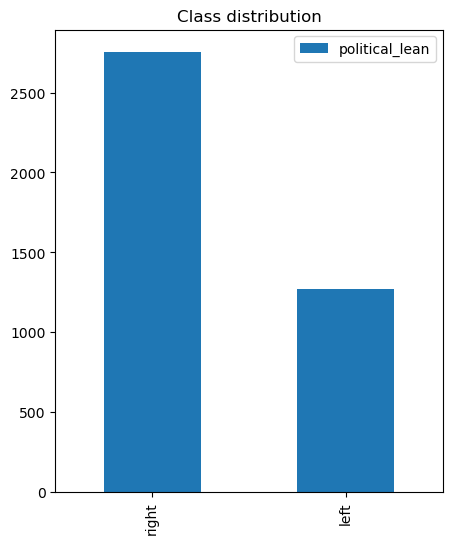

In [15]:
slct_tbl_full_df03['political_lean'].value_counts().plot(kind="bar",
                                                         legend=True,
                                                         figsize=(5,6),
                                                         title='Class distribution')

### Plot word counts

source_name
Breitbart News         Axes(0.125,0.11;0.775x0.77)
CNN                    Axes(0.125,0.11;0.775x0.77)
Fox News               Axes(0.125,0.11;0.775x0.77)
The Washington Post    Axes(0.125,0.11;0.775x0.77)
Name: word_cnt, dtype: object

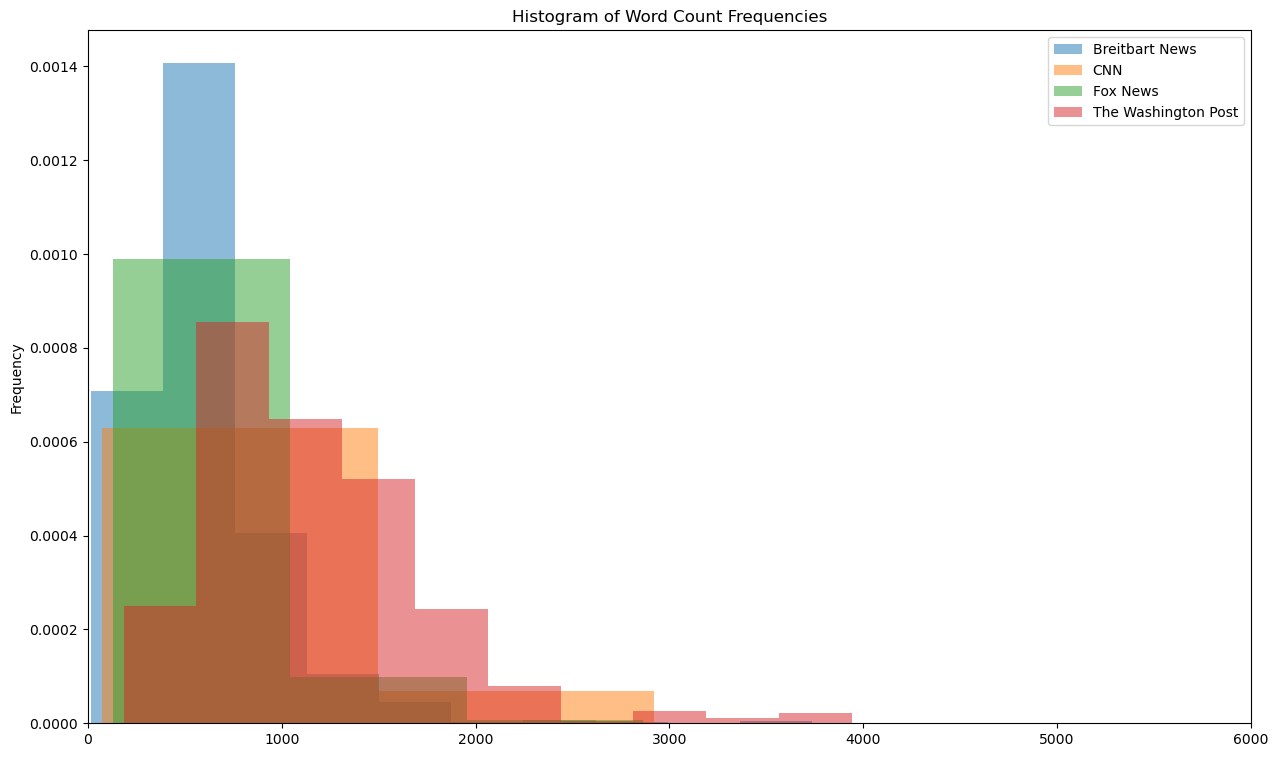

In [16]:
slct_tbl_full_df03.groupby('source_name')['word_cnt'].plot(kind="hist",
                                                           density=True,
                                                           alpha=0.5,
                                                           legend=True,
                                                           figsize=(15,9),
                                                           title='Histogram of Word Count Frequencies',
                                                           xlim=(0,6000))

## Data preprocessing

### Case-loading

In [17]:
slct_tbl_full_df03['lower'] = slct_tbl_full_df03['article_text'].apply(str.lower)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

(4026, 12)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  
0           left  travelers in alabama driving on interstate 65 ...  
1           left  a federal prosecutor may be nearing a decision...  
2           left  a federal appeals court tuesday cleared the wa...  
3           left  speaking in orlando in november 2015, republic...  
4           left  “look, we know our country’s going in the wron...

### Text normalization

In [18]:
import textacy.preprocessing as tprep

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

slct_tbl_full_df03['norm'] = slct_tbl_full_df03['lower'].apply(normalize)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,5):
    try:
        print(slct_tbl_full_df03['norm'][c], '\n')
    except:
        print(f'Skip {c}')

(4026, 13)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  
0  travelers in alabama driving on interstate 65 ...  
1  a federal prosecutor may be nearing a decision...  
2  a federal appeals court tuesday cleared the wa...  
3  speaking in orlando in november 2015, republic...  
4  "look, we know our country's going in the wron...

travelers in alabama driving on interstate 65 to parties and barbecues on memorial day might have seen messages on digital road signs honoring veterans who died fighting for the united states. but that's not what some drivers near clanton, ala., saw on monday. instead, motorists reported seeing a sign that was apparently hacked to display the words "reclaim america," a white nationalist slogan, and "patriot front us," referencing the white supremacist group that was involved in the deadly 2017 unite the right rally in charlottesville. "how does this come about?" wrote sarah hughes, a motorist who captured photos of the sign and posted them on twitter. "weird as hell."  a contractor's portable message board was hacked on i-65 in chilton county, ala., on monday afternoon, john mcwilliams, a spokesman for the alabama department of transportation (aldot) west central region, told the washington post in a statement. "a citizen alerted a nearby state trooper about the message, who then conta

### Remove special characters

In [19]:
'''Complex citation (add lambda):
https://chat.openai.com/share/a135754c-c38c-47ea-8f83-54d41d5397ab'''
rex_u_code = rex.compile(r'\\u20[\w]{2}')
slct_tbl_full_df03['replace'] = slct_tbl_full_df03['norm'].apply(lambda x: x.replace('&nbsp;', ' ').replace('\\n', ' ').replace('\u2063', ' ').replace('\u2066', ' ').replace('\u2069', ' ').replace('\u200b', ' ').replace('\u200d', ' '))
#slct_tbl_full_df03['replace_a'] = slct_tbl_full_df03['norm'].apply(lambda x: x.replace('&nbsp;', ' '))
#slct_tbl_full_df03['replace'] = slct_tbl_full_df03['replace_a'].apply(lambda x: rex_u_code.sub(' ', x))
#re.sub(pattern, replacement, string)

### Lemmatization using spaCY

In [20]:
nlp_trans01 = spacy.load('en_core_web_sm')

def lemma(text):
    trans_txt = nlp_trans01(text)
    return [t.lemma_ for t in trans_txt]

# Start timer
start_time = dt.datetime.today()

slct_tbl_full_df03['lemma'] = slct_tbl_full_df03['replace'].progress_apply(lemma)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,5):
    try:
        print(slct_tbl_full_df03['lemma'][c], '\n')
    except:
        print(f'Skip {c}')

100%|█████████| 4026/4026 [08:03<00:00,  8.33it/s]

(4026, 15)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               lemma  
0  [traveler, in, alabama, drive, on, interstate,...  
1  [a, federal, prosecutor, may, be, near, a, dec...  
2  [a, federal, appeal, court, tuesday, clear, th...  
3  [speak, in, orlando, in, november, 2015, ,, re...  
4  [", look, ,, we, know, our, country, 's, go, i...

['traveler', 'in', 'alabama', 'drive', 'on', 'interstate', '65', 'to', 'party', 'and', 'barbecue', 'on', 'memorial', 'day', 'might', 'have', 'see', 'message', 'on', 'digital', 'road', 'sign', 'honor', 'veteran', 'who', 'die', 'fight', 'for', 'the', 'united', 'states', '.', 'but', 'that', 'be', 'not', 'what', 'some', 'driver', 'near', 'clanton', ',', 'ala', '.', ',', 'see', 'on', 'monday', '.', 'instead', ',', 'motorist', 'report', 'see', 'a', 'sign', 'that', 'be', 'apparently', 'hack', 'to', 'display', 'the', 'word', '"', 'reclaim', 'america', ',', '"', 'a', 'white', 'nationalist', 'slogan', ',', 'and', '"', 'patriot', 'front', 'we', ',', '"', 'reference', 'the', 'white', 'supremacist', 'group', 'that', 'be', 'involve', 'in', 'the', 'deadly', '2017', 'unite', 'the', 'right', 'rally', 'in', 'charlottesville', '.', '"', 'how', 'do', 'this', 'come', 'about', '?', '"', 'write', 'sarah', 'hughes', ',', 'a', 'motorist', 'who', 'capture', 'photo', 'of', 'the', 'sign', 'and', 'post', 'they', '

### Split

In [21]:
slct_tbl_full_df03['split'] = slct_tbl_full_df03['replace'].apply(str.split)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,100):
    try:
        print(slct_tbl_full_df03['split'][c], '\n')
    except:
        print(f'Skip {c}')

(4026, 16)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               lemma  \
0  [traveler, in, alabama, drive, on, interstate,...   
1  [a, federal, prosecutor, may, be, near, a, dec...   
2  [a, federal, appeal, court, tuesday, clear, th...   
3  [speak, in, orlando, in, november, 2015, ,, re...   
4  [", look, ,, we, know, our, country, 's, go, i...   

                                               split  
0  [travelers, in, alabama, driving, on, intersta...  
1  [a, federal, prosecutor, may, be, nearing, a, ...  
2  [a, federal, appeals, court, tuesday, cleared,...  
3  [speaking, in, orlando, in, november, 2015,, r...  
4  ["look,, we, know, our, country's, going, in, ...

['travelers', 'in', 'alabama', 'driving', 'on', 'interstate', '65', 'to', 'parties', 'and', 'barbecues', 'on', 'memorial', 'day', 'might', 'have', 'seen', 'messages', 'on', 'digital', 'road', 'signs', 'honoring', 'veterans', 'who', 'died', 'fighting', 'for', 'the', 'united', 'states.', 'but', "that's", 'not', 'what', 'some', 'drivers', 'near', 'clanton,', 'ala.,', 'saw', 'on', 'monday.', 'instead,', 'motorists', 'reported', 'seeing', 'a', 'sign', 'that', 'was', 'apparently', 'hacked', 'to', 'display', 'the', 'words', '"reclaim', 'america,"', 'a', 'white', 'nationalist', 'slogan,', 'and', '"patriot', 'front', 'us,"', 'referencing', 'the', 'white', 'supremacist', 'group', 'that', 'was', 'involved', 'in', 'the', 'deadly', '2017', 'unite', 'the', 'right', 'rally', 'in', 'charlottesville.', '"how', 'does', 'this', 'come', 'about?"', 'wrote', 'sarah', 'hughes,', 'a', 'motorist', 'who', 'captured', 'photos', 'of', 'the', 'sign', 'and', 'posted', 'them', 'on', 'twitter.', '"weird', 'as', 'hell

### Remove stop words

In [22]:
sw = stopwords.words("english")

# Add additional stop words
sw.extend(['',
           '️',
           'arent',
           'cannot',
           'cant',
           'couldnt',
           'couldve',
           'didnt',
           'doesnt',
           'dont',
           'hadnt',
           'hasnt',
           'havent',
           'hes',
           'im',
           "i'm",
           'isnt',
           'it’s',
           'ive',
           '𝚘𝚏',
           'mightnt',
           'mustnt',
           'neednt',
           'shant',
           'shes',
           'shouldnt',
           'shouldve',
           'thatll',
           'theyll',
           'theyve',
           'wasnt',
           'werent',
           'whats',
           'weve',
           'wont',
           'wouldnt',
           'wouldve',
           'yall',
           'youd',
           'youll',
           'youre',
           'youve',
           "we'll",
           "you’re",
           "you’ve",
           "you’ll",
           "you’d",
           "she’s",
           "it’s",
           "that’ll",
           "don’t",
           "should’ve",
           "aren’t",
           "couldn’t",
           "didn’t",
           "doesn’t",
           "hadn’t",
           "hasn’t",
           "haven’t",
           "isn’t",
           "mightn’t",
           "mustn’t",
           "needn’t",
           "shan’t",
           "shouldn’t",
           "wasn’t",
           "weren’t",
           "won’t",
           "wouldn’t",
           "i’m",
           "we’ll",
           'said',
           'told',
           'according',])

print(sw)

def sw_remover(tokens):
    return [t for t in tokens if t.lower() not in sw]

slct_tbl_full_df03['no_sw'] = slct_tbl_full_df03['split'].apply(sw_remover)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,2):
    print(slct_tbl_full_df03['no_sw'][c])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               lemma  \
0  [traveler, in, alabama, drive, on, interstate,...   
1  [a, federal, prosecutor, may, be, near, a, dec...   
2  [a, federal, appeal, court, tuesday, clear, th...   
3  [speak, in, orlando, in, november, 2015, ,, re...   
4  [", look, ,, we, know, our, country, 's, go, i...   

                                               split  \
0  [travelers, in, alabama, driving, on, intersta...   
1  [a, federal, prosecutor, may, be, nearing, a, ...   
2  [a, federal, appeals, court, tuesday, cleared,...   
3  [speaking, in, orlando, in, november, 2015,, r...   
4  ["look,, we, know, our, country's, going, in, ...   

                                               no_sw  
0  [travelers, alabama, driving, interstate, 65, ...  
1  [federal, prosecutor, may, nearing, decision, ...  
2  [federal, appeals, court, tuesday, cleared, wa...  
3  [speaking, orlando, november, 2015,, republica...  
4  ["look,, know, country's, going, wrong, direct...

['travelers', 'alabama', 'driving', 'interstate', '65', 'parties', 'barbecues', 'memorial', 'day', 'might', 'seen', 'messages', 'digital', 'road', 'signs', 'honoring', 'veterans', 'died', 'fighting', 'united', 'states.', "that's", 'drivers', 'near', 'clanton,', 'ala.,', 'saw', 'monday.', 'instead,', 'motorists', 'reported', 'seeing', 'sign', 'apparently', 'hacked', 'display', 'words', '"reclaim', 'america,"', 'white', 'nationalist', 'slogan,', '"patriot', 'front', 'us,"', 'referencing', 'white', 'supremacist', 'group', 'involved', 'deadly', '2017', 'unite', 'right', 'rally', 'charlottesville.', '"how', 'come', 'about?"', 'wrote', 'sarah', 'hughes,', 'motorist', 'captured', 'photos', 'sign', 'posted', 'twitter.', '"weird', 'hell."', "contractor's", 'portable', 'message', 'board', 'hacked', 'i-65', 'chilton', 'county,', 'ala.,', 'monday', 'afternoon,', 'john', 'mcwilliams,', 'spokesman', 'alabama', 'department', 'transportation', '(aldot)', 'west', 'central', 'region,', 'washington', 'po

### Rejoin semi-processed tokens

In [23]:
slct_tbl_full_df03['no_sw_join'] = slct_tbl_full_df03['no_sw'].apply(" ".join)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,2):
    print(slct_tbl_full_df03['no_sw_join'][c])

(4026, 18)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               lemma  \
0  [traveler, in, alabama, drive, on, interstate,...   
1  [a, federal, prosecutor, may, be, near, a, dec...   
2  [a, federal, appeal, court, tuesday, clear, th...   
3  [speak, in, orlando, in, november, 2015, ,, re...   
4  [", look, ,, we, know, our, country, 's, go, i...   

                                               split  \
0  [travelers, in, alabama, driving, on, intersta...   
1  [a, federal, prosecutor, may, be, nearing, a, ...   
2  [a, federal, appeals, court, tuesday, cleared,...   
3  [speaking, in, orlando, in, november, 2015,, r...   
4  ["look,, we, know, our, country's, going, in, ...   

                                               no_sw  \
0  [travelers, alabama, driving, interstate, 65, ...   
1  [federal, prosecutor, may, nearing, decision, ...   
2  [federal, appeals, court, tuesday, cleared, wa...   
3  [speaking, orlando, november, 2015,, republica...   
4  ["look,, know, country's, going, wrong, direct... 

travelers alabama driving interstate 65 parties barbecues memorial day might seen messages digital road signs honoring veterans died fighting united states. that's drivers near clanton, ala., saw monday. instead, motorists reported seeing sign apparently hacked display words "reclaim america," white nationalist slogan, "patriot front us," referencing white supremacist group involved deadly 2017 unite right rally charlottesville. "how come about?" wrote sarah hughes, motorist captured photos sign posted twitter. "weird hell." contractor's portable message board hacked i-65 chilton county, ala., monday afternoon, john mcwilliams, spokesman alabama department transportation (aldot) west central region, washington post statement. "a citizen alerted nearby state trooper message, contacted aldot," mcwilliams tuesday. "aldot personnel immediately responded turned message board off. message boards i-65 affected." mcwilliams added aldot investigating white supremacist language appeared sign nea

### Remove punctuation

In [24]:
punctuation = set(punctuation) # speeds up comparison
print(punctuation)

# Add special hyphen mark
tw_punct = punctuation - {"#"}
print(tw_punct)
# Remove hash and at symbols for later capture of hashtag info
tw_punct = tw_punct - {"@"}
tw_punct = tw_punct - {"-"}
tw_punct.add("’")
tw_punct.add("‘")
tw_punct.add("”")
tw_punct.add("“")
tw_punct.add("…")
tw_punct.add("—")
tw_punct.add("...")

print(tw_punct)

{'{', '$', '.', '@', '|', '>', '#', "'", '^', '"', ',', '?', '<', '(', '`', '-', '&', '/', '~', '!', ':', '=', '}', ')', '%', '\\', '*', '[', ';', '+', '_', ']'}
{'{', '$', '.', '@', '|', '>', "'", '^', '"', ',', '?', '<', '(', '`', '-', '&', '/', '~', '!', ':', '=', '}', ')', '%', '\\', '*', '[', ';', '+', '_', ']'}
{'{', '<', '(', '`', '‘', '—', '&', '$', '“', '…', '.', '/', '"', '~', '’', '...', '|', '>', '!', ':', '=', ',', '”', '}', ')', '%', '\\', '*', "'", '^', ';', '[', '+', '_', ']', '?'}


In [25]:
def remove_punctuation(text, punct_set=punctuation): 
    return("".join([ch for ch in text if ch not in punct_set]))

slct_tbl_full_df03['no_sw_join_no_punc'] = slct_tbl_full_df03['no_sw_join'].apply(remove_punctuation, punct_set=tw_punct)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,10):
    try:
        print(slct_tbl_full_df03['no_sw_join_no_punc'][c], '\n')
    except:
        print(f'\nerror on {c}\n')

(4026, 19)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               lemma  \
0  [traveler, in, alabama, drive, on, interstate,...   
1  [a, federal, prosecutor, may, be, near, a, dec...   
2  [a, federal, appeal, court, tuesday, clear, th...   
3  [speak, in, orlando, in, november, 2015, ,, re...   
4  [", look, ,, we, know, our, country, 's, go, i...   

                                               split  \
0  [travelers, in, alabama, driving, on, intersta...   
1  [a, federal, prosecutor, may, be, nearing, a, ...   
2  [a, federal, appeals, court, tuesday, cleared,...   
3  [speaking, in, orlando, in, november, 2015,, r...   
4  ["look,, we, know, our, country's, going, in, ...   

                                               no_sw  \
0  [travelers, alabama, driving, interstate, 65, ...   
1  [federal, prosecutor, may, nearing, decision, ...   
2  [federal, appeals, court, tuesday, cleared, wa...   
3  [speaking, orlando, november, 2015,, republica...   
4  ["look,, know, country's, going, wrong, direct... 

travelers alabama driving interstate 65 parties barbecues memorial day might seen messages digital road signs honoring veterans died fighting united states thats drivers near clanton ala saw monday instead motorists reported seeing sign apparently hacked display words reclaim america white nationalist slogan patriot front us referencing white supremacist group involved deadly 2017 unite right rally charlottesville how come about wrote sarah hughes motorist captured photos sign posted twitter weird hell contractors portable message board hacked i-65 chilton county ala monday afternoon john mcwilliams spokesman alabama department transportation aldot west central region washington post statement a citizen alerted nearby state trooper message contacted aldot mcwilliams tuesday aldot personnel immediately responded turned message board off message boards i-65 affected mcwilliams added aldot investigating white supremacist language appeared sign near clanton 40 miles northwest montgomery al

### Tokenize

In [26]:
slct_tbl_full_df03['no_sw_join_no_punc_tok'] = slct_tbl_full_df03['no_sw_join_no_punc'].apply(str.split)

print(slct_tbl_full_df03.shape)
display(slct_tbl_full_df03.head())

for c in range(0,2):
    print(slct_tbl_full_df03['no_sw_join_no_punc_tok'][c], '\n')

(4026, 20)


index          source_name          author  \
0      0  The Washington Post             NaN   
1      1  The Washington Post  Amber Phillips   
2      2  The Washington Post    David Ovalle   
3      3  The Washington Post     Philip Bump   
4      5  The Washington Post    Paul Waldman   

                                               title  \
0  Alabama Highway sign hacked with white suprema...   
1  Breaking down the GOP investigation into the B...   
2  Appeals court paves way for Purdue Pharma opio...   
3  Trump pledges to win an immigration fight he d...   
4  Why fear of change will drive the GOP presiden...   

                                                 url          publish_date  \
0  https://www.washingtonpost.com/nation/2023/05/...  2023-05-30T16:31:36Z   
1  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T19:56:33Z   
2  https://www.washingtonpost.com/health/2023/05/...  2023-05-30T23:52:34Z   
3  https://www.washingtonpost.com/politics/2023/0...  2023-05-30T18:30:47Z   
4  https://www.washingtonpost.com/opinions/2023/0...  2023-05-30T10:00:00Z   

                                             content  \
0  Travelers in Alabama driving on Interstate 65 ...   
1  Comment on this story\r\nComment\r\nA federal ...   
2  Comment on this story\r\nComment\r\nA federal ...   
3  Comment on this story\r\nComment\r\nSpeaking i...   
4  Comment on this story\r\nComment\r\nLook, we k...   

                                        article_text  char_cnt  word_cnt  \
0  Travelers in Alabama driving on Interstate 65 ...      5746       920   
1  A federal prosecutor may be nearing a decision...      6814      1089   
2  A federal appeals court Tuesday cleared the wa...      5479       869   
3  Speaking in Orlando in November 2015, Republic...      5907       955   
4  “Look, we know our country’s going in the wron...      4563       750   

  political_lean                                              lower  \
0           left  travelers in alabama driving on interstate 65 ...   
1           left  a federal prosecutor may be nearing a decision...   
2           left  a federal appeals court tuesday cleared the wa...   
3           left  speaking in orlando in november 2015, republic...   
4           left  “look, we know our country’s going in the wron...   

                                                norm  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                             replace  \
0  travelers in alabama driving on interstate 65 ...   
1  a federal prosecutor may be nearing a decision...   
2  a federal appeals court tuesday cleared the wa...   
3  speaking in orlando in november 2015, republic...   
4  "look, we know our country's going in the wron...   

                                               lemma  \
0  [traveler, in, alabama, drive, on, interstate,...   
1  [a, federal, prosecutor, may, be, near, a, dec...   
2  [a, federal, appeal, court, tuesday, clear, th...   
3  [speak, in, orlando, in, november, 2015, ,, re...   
4  [", look, ,, we, know, our, country, 's, go, i...   

                                               split  \
0  [travelers, in, alabama, driving, on, intersta...   
1  [a, federal, prosecutor, may, be, nearing, a, ...   
2  [a, federal, appeals, court, tuesday, cleared,...   
3  [speaking, in, orlando, in, november, 2015,, r...   
4  ["look,, we, know, our, country's, going, in, ...   

                                               no_sw  \
0  [travelers, alabama, driving, interstate, 65, ...   
1  [federal, prosecutor, may, nearing, decision, ...   
2  [federal, appeals, court, tuesday, cleared, wa...   
3  [speaking, orlando, november, 2015,, republica...   
4  ["look,, know, country's, going, wrong, direct... 

['travelers', 'alabama', 'driving', 'interstate', '65', 'parties', 'barbecues', 'memorial', 'day', 'might', 'seen', 'messages', 'digital', 'road', 'signs', 'honoring', 'veterans', 'died', 'fighting', 'united', 'states', 'thats', 'drivers', 'near', 'clanton', 'ala', 'saw', 'monday', 'instead', 'motorists', 'reported', 'seeing', 'sign', 'apparently', 'hacked', 'display', 'words', 'reclaim', 'america', 'white', 'nationalist', 'slogan', 'patriot', 'front', 'us', 'referencing', 'white', 'supremacist', 'group', 'involved', 'deadly', '2017', 'unite', 'right', 'rally', 'charlottesville', 'how', 'come', 'about', 'wrote', 'sarah', 'hughes', 'motorist', 'captured', 'photos', 'sign', 'posted', 'twitter', 'weird', 'hell', 'contractors', 'portable', 'message', 'board', 'hacked', 'i-65', 'chilton', 'county', 'ala', 'monday', 'afternoon', 'john', 'mcwilliams', 'spokesman', 'alabama', 'department', 'transportation', 'aldot', 'west', 'central', 'region', 'washington', 'post', 'statement', 'a', 'citizen'

### Display globablly unqiue tokens on first split

In [27]:
slct_tbl_full_df03s1 = pd.Series(slct_tbl_full_df03['split'])

all_tokens_lst01 = []

[all_tokens_lst01.append(f) for f in slct_tbl_full_df03s1]
all_tokens_lst01 = list(itertools.chain.from_iterable(all_tokens_lst01))
all_tokens_set01 = set(all_tokens_lst01)
print(len(sorted(all_tokens_set01)))
print(sorted(all_tokens_set01))

128562
['!', '!!', '!!!', '!!️', '!"', '!)', '!function(){"use', '"', '""i\'ve', '""while', '"#ad', '"#bamarush"', '"#boycottpetsmart."', '"#budlightpartner"', '"#budlightpartner."', '"#cannesyounot."', '"#desaster,"', '"#f--ktheblue,"', '"#justiceforjohncoughlin"', '"#metoo"', '"#thejohniknew."', '"#uncletimisanuncletom."', '"$1', '"$1.2', '"$2.9', '"$22', '"$3', '"$600', '"$8.41', '"\'a', '"\'agreed', '"\'ban\'', '"\'beyond', '"\'but', '"\'cannot', '"\'defund', '"\'did', '"\'durham', '"\'evidence-based', '"\'gender-affirming', '"\'health', '"\'heartbreaking\'', '"\'hey', '"\'high-profile,', '"\'home', '"\'i', '"\'i\'m', '"\'in', '"\'indirect', '"\'institution[s]', '"\'it\'s', '"\'justified\'', '"\'like,', '"\'mentally', '"\'open', '"\'protect', '"\'rob\'', '"\'rob,\'', '"\'survivors', '"\'the', '"\'there\'s', '"\'they\'re', '"\'til', '"\'tippy-toeing\'', '"\'top', '"\'upvoting\'', '"\'viewpoints\'', '"\'we', '"\'we\'re', '"\'what', '"\'what\'s', '"\'women', '"\'you', '"(a)s', '"(ader

### Display globablly unqiue tokens on final tokens

In [28]:
import itertools
slct_tbl_full_df03s1 = pd.Series(slct_tbl_full_df03['no_sw_join_no_punc_tok'])

all_tokens_lst01 = []

[all_tokens_lst01.append(f) for f in slct_tbl_full_df03s1]
all_tokens_lst01 = list(itertools.chain.from_iterable(all_tokens_lst01))
all_tokens_set01 = set(all_tokens_lst01)
print(len(sorted(all_tokens_set01)))
print(sorted(all_tokens_set01))

63343
['#1', '#10', '#11julio', '#14', '#1496', '#15', '#150', '#1576', '#181', '#19', '#2', '#2019ncov', '#2024election', '#22', '#227', '#25', '#30', '#35', '#42', '#49', '#4u', '#5', '#52', '#58', '#592', '#6', '#7', '#8', '#838', '#9', '#94', '#99', '#abajoladictadura', '#acnepositivity', '#ad', '#afghanevac', '#ai', '#aivoiceover', '#alpolitics', '#americandrag', '#andyvermautthanksyou', '#angeladavis', '#antifa', '#antisemitism', '#asia', '#auspol', '#avl', '#avlnews', '#azucenaalas10', '#babynames', '#bamarush', '#bansoffourbodies', '#baphomet', '#bch', '#beijing', '#bidenbordercrisis', '#bidenborderinvasion', '#bigguy', '#billsmafia', '#blackrock', '#bodyhairpositivity', '#bordercrisis', '#boycott', '#boycottkohls', '#boycottpetsmart', '#boycotttarget', '#breaking', '#breakingnews', '#budlightamendment', '#budlightpartner', '#bus', '#busdriver', '#caimanera', '#canciller', '#cannesyounot', '#carreramujer', '#ccpchina', '#cdnpoli', '#cena', '#chile', '#china', '#cibercuba', '#cl

### Display globablly unqiue tokens on lemmas

In [29]:
slct_tbl_full_df03s1 = pd.Series(slct_tbl_full_df03['lemma'])

all_tokens_lst01 = []

[all_tokens_lst01.append(f) for f in slct_tbl_full_df03s1]
all_tokens_lst01 = list(itertools.chain.from_iterable(all_tokens_lst01))
all_tokens_set01 = set(all_tokens_lst01)
print(len(sorted(all_tokens_set01)))
print(sorted(all_tokens_set01))

44645
['\n', '\n\n', '\n\n\n\n         ', '\n\n\n\n           ', '\n\n\n          ', '\n\n ', '\n\n         ', '\n ', '\n    \n    \n      ', '\n      \n    \n     ', '\n        ', '\n        \n', '\n        \n\n\n', '\n        \n\n\n\n', '\n        \n\n\n\n\n', '\n        \n\n\n\n\n\n', '\n        \n\n\n\n\n\n\n', '\n        \n\n\n\n\n\n\n\n', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n             ', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n             ', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n             ', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n         ', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            ', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          ', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n         ', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n           ', '\n        \n\n\n\n\n\n\n\n\n\n\n\n\n  

### 